# Seattle Street Quality
<dl>
  <dt>By Paul Wright</dt>
  <dt> This investigation is part of the University of Washington's Data Science Master Program</dt>
</dl>

This project was completed as part of the University of Washington's DATA512 class on Human Centered Data Science. More information about the course and the project requirements can be found [here](https://wiki.communitydata.cc/Human_Centered_Data_Science_(Fall_2018).  

The next section contains a table of contents. Sections 1-5 contain a report with visualizations on the findings. The appendix contains code and output of how the visualizations and report were created.



---
### Table of Contents
- [Section 1: Background and Motivation](#background)
- [Section 2: Raw Data](#raw-data)
- [Section 3: Project Plan, Pre-Processing and Data Cleanup](#plan)
 - [Section 3a: Creating the Region Flag](#region)
 - [Section 3b: Creating the Condition Buckets](#condition)
 - [Section 3c: Data Cleanup and Concerns](#cleanup)
- [Section 4: Results](#results)
 - [Section 4a: Missing or Bad Data](#bad-data)
 - [Section 4b: Cumulative Percent of Roads Plot](#road-qual)
 - [Section 4c: Road Type Analysis](#road-type)
- [Section 5: Conclusion](#conclusion)
- [Appendix : The Code](#code)
 - [Appendix 1: Setup and Infrastructure](#setup)
     - [Appendix 1a: Creating the Regions](#region-code)
     - [Appendix 1b: Creating the Condition Buckets](#condition-code)
 - [Appendix 2: Previewing the Data](#preview-code)
 - [Appendix 3: Data Cleanup](#cleanup-code)
 - [Appendix 4: Results](#results-code)
     - [Appendix 4a: Creating the Cumulative Percent of Roads Plot](#results-agg-code)
     - [Appendix 4b: Road Type Analysis](#results-type-code)


---
<div id='background'/>
## Background and Motivation 

Using Seattle road quality data, we analyzed how road quality varies across the different sections of Seattle to evaluate whether road maintanence varies across different areas of the city. Visibility into infrastructure spend and infrastructure quality is important for holding our government accountable. This drive for visibility is exactly why Seattle has chosen to expose their data for analysis on seattle.gov. While we don't expect to find anything problematic or troublesome, we hope that this analysis brings some light to the road quality across different sections of Seattle.

<div id='raw-data'/>
## Raw Data
To do this, we used data from the city of seattle that has road name, location, quality, designation (e.g. arterial), length and surface type, among other characteristics. The data can be found [here](http://data-seattlecitygis.opendata.arcgis.com/datasets/383027d103f042499693da22d72d10e3_0?geometry=-122.534%2C47.563%2C-122.097%2C47.644&page=2&selectedAttribute=PVMTCONDINDX1) with information about the columns [here](https://data.seattle.gov/Transportation/Seattle-Streets/jc8u-fewc). This data is updated monthly with updated road quality data. While there are many attributes in this dataset, we focus on the pavement condition and location, as described below, to understand road quality.

The terms of use of the data, as stated [here](http://www.seattle.gov/tech/initiatives/privacy/data-we-collect), ouline that "Seattle has long led the way in providing open data sets to the public. These are reviewed, scrubbed of personally identifiable information and made available to the public for research, entrepreneurial uses and general information to City residents.".

Seattle.gov does caveat their data [here](https://data.seattle.gov/stories/s/Data-Policy/6ukr-wvup/) that: 

"The data made available here has been modified for use from its original source, which is the City of Seattle. Neither the City of Seattle nor the Office of the Chief Technology Officer (OCTO) makes any claims as to the completeness, timeliness, accuracy or content of any data contained in this application; makes any representation of any kind, including, but not limited to, warranty of the accuracy or fitness for a particular use; nor are any such warranties to be implied or inferred with respect to the information or data furnished herein. The data is subject to change as modifications and updates are complete. It is understood that the information contained in the web feed is being used at one's own risk."

GIS data (which we will not be using other than to leverage the non-GIS components) are designated as follows (from [here](https://www.arcgis.com/sharing/rest/content/items/383027d103f042499693da22d72d10e3/info/metadata/metadata.xml?format=default&output=html)):

"Use Constraints: PDDL | This item is meant for public access and use.  The City of Seattle makes no representation or warranty as to its accuracy. Important | The City of Seattle has created this service for our GIS Open Data website. We do reserve the right to alter, suspend, re-host, or retire this service at any time and without notice. GIS staff will provide notification of changes via the Comments RSS capability in ArcGIS Online."

Here are the main columns we will be using for this analysis with 2 example rows. There are other columns as well but this will be the primary data used for the analysis.


Example data:

| Column Name   | Description                | Example 1               | Example 2                 |
|---------------|----------------------------|-------------------------|---------------------------|
| STNAME_ORD    | Name of the street         | 1ST AVE                 | 1ST AVE NE                |
| ARTDESCRIPT   | Arterial Designation       | Minor Arterial          | Not Designated            |
| SPEEDLIMIT    | Speed Limit                | 25                      | 20                        |
| SURFACETYPE_1 | Surface Type               | AC/PCC                  | PCC                       |
| STREETTYPE    | Street Type                | Downtown Neighborhood   | Neighborhood Yield Street |
| PVMTCONDINDX1 | Pavement Condition (0-100) | 19                      | 35                        |

<div id='plan'/>
## Project Plan, Pre-Processing and Data Cleanup

To understand how street conditions vary across different areas of the city, we will first do some data cleansing and then perform the analysis using the Pandas package in a Jupyter Notebook. 

Before we can begin, we must create 2 new data columns; region and condition (used to bucket the road quality score into quintiles).
<div id='region'/>
### Creating the Region Flag

The first contains flags for the different areas of the city since we do not have a mapping to zip code or other identification. To do this, we will leverage the street names - specifically the cardinal direction associated with the street name as these are indicative of the location. We will be comparing NE, N, NW, E, S, SW, W, Central District and downtown (or lack of a cardinal direction). Here are some examples of how the street cardinality is assigned.

<img src="region_assignment.png" width="500">

We are able to use this type of assignment because the city of Seattle is layed out in this way. As we see from Wikipedia, here is how streets are designated:

<img src="Seattle_WA_Directional_Zones_v10-14-16.png" width="200">

Source: Map was gathered from [Wikimedia](https://en.wikipedia.org/wiki/File:Seattle_WA_Directional_Zones_v10-14-16.svg#metadata), Wikimedia Foundation, 2018. CC-BY-SA 4.0 International.

Our regions mimic this layout exactly, with the gray being downtown and the 'E st' being 'Central District', a designation we can get from the dataset because downtown streets are classified as such in the 'streettype' column.
<div id='condition'/>
### Creating the Condition Buckets

The raw condition score, PVMTCONDINDX1, is a score from 0 to 100. We create buckets to categorize road conditions using quintiles. For this, we put roads with score 1-20 in bucket '20', 21-40 in bucket '40' and so on up to 100. We break out 0 separately to understand what is happening in these buckets. There are also 11 roads that have no score and will be assigned a condition value of -1.


<div id='cleanup'/>
### Data Cleanup and Concerns

After we assign the region and create the condition buckets, we then remove any streets that are missing data or do not have an associated region. Most of these cases are because of the following reasons:

* The data point is a boundary of regions or 
* The data point is a non-traditional roads like ramps and bridges or
* The data point is a bike trail


After cleaning the data, we analyzed coverage and quality of streets across Seattle. These include the percent of streets with no quality score or a 0 quality score, the cumulative percent of streets with any given quality score and breakdowns of average street condition by street designation. From this, we are able to compare differences across the different sections of the city.

<div id='results'/>
## Results

Here we analyze the road condition data to understand and visualize the differences between different regions. We break this out into 3 sections: 1) regions with a high number of missing condition data or condition data of 0, 2) a cumulative road quality analysis and 3) a road type analysis.

To begin, we look at the number of roads that fall in each condition bucket by region. The below table shows this breakout.

<img src="road_qual_table.png" width="400">

### Low or Missing Data
<div id='bad-data'/>

First, we focus on the roads in the -1 (no condition available) and 0 buckets as these are either 1) very bad road conditions or 2) inaccurate data. In either case, looking at these particular groups as a percentage of each regions total, we see that the Central District and W have the highest percent of streets with a value of 0.

<img src="road_qual_perc_0.png" width="300">

### Cumulative Road Quality Analysis
<div id='road-qual'/>
To understand the distribution of streets with a value greater than 0, we create a cumulative percent of street measure by street quality which is plotted below. The green line, for NE, is consistenly below the other lines while the grey line, for the central district, is consistenly near the top. This indicates that NE has the best road conditions while central district has the worst. Take, for example, a road quality of 40. NE and Central District have value sof 12.4% and 53.4%, respectively, meaning that 12.4% of the roads in the NE have a condition score of less than or equal to 40 and 53.4% of roads in the Central District have a condition score of less than or equal to 40. This shows that the NE clearly has better roads than the Central District, especially since this is true for every road quality value.

<img src="road_qual_graph.png" width="500">

From this, we see E and Central District consistently have the worst street quality, while all of the others are very similar in trend and performance.

### Road Type Analysis
<div id='road-type'/>


The dataset contains a few types of roads.  The possible types ares: 

* AC = Asphalt Concrete
* PCC = Rigid Pavement
* AC/PCC = Composite AC and PCC
* ST = Bituminous Surface Treatment


Analyzing the breakout for each group, we see that E and Central District have a higher percentage of AC road than the other types.

<img src="road_type_ct.png" width="400">

The AC roads, as seen in the last table, have the lowest quality scores. These roads are the driving factor of why the Central District and E have the worst roads.

<img src="road_type_cond.png" width="400">

<div id='conclusion'/>
### Conclusion

Central District and W have the highest number of streets with a value of 0, indicating either that these have some of the worst streets in the city or the mechanism used to collect this data is biased against those areas. 

Central District and E have the worst performance when looking at the cumulative road quality graph and are very different from all of the other regions (which are very similar to each other). The NE and SW have the best roads as shown in the cumulative road quality graph.

The main driver for Central District and E being worse than the other areas is that these regions have a higher percentage of Asphalt Concrete roads, and these roads have lower condition scores than other types of roads.

Overall, we see a very equitable comparison of road conditions across different regions of the city with the exception of E and Central District, which perform worse than the other regions.

--- 
***
___


# Appendix: The Code
<div id='results'/>

The rest of this file contains the code to perform the analysis above. We have included to 1) provide transparency into how the data was manipulated and reported and 2) enable users to reproduce or expand the given analysis.

<div id='setup'/>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#import data
data = pd.read_csv('Seattle_Streets.csv')
data.fillna("",inplace=True)

In [104]:
data.head()

,OBJECTID,ARTCLASS,COMPKEY,UNITIDSORT,UNITDESC,STNAME_ORD,XSTRLO,XSTRHI,ARTDESCRIPT,OWNER,...,STREETTYPE,PVMTCONDINDX1,PVMTCONDINDX2,TRANCLASS,TRANDESCRIPT,SLOPE_PCT,PVMTCATEGORY,SHAPE_Length,condition,region
0,1,2,1002,100080,1ST AVE BETWEEN COLUMBIA ST AND MARION ST,1ST AVE,COLUMBIA ST,MARION ST,Minor Arterial,,...,Downtown Neighborhood,19,0,1,PRINCIPAL TRANSIT ROUTE,1,ART,305.996038,20,downtown
1,2,2,1020,100280,1ST AVE BETWEEN CLAY ST AND BROAD ST,1ST AVE,CLAY ST,BROAD ST,Minor Arterial,,...,Downtown Neighborhood,48,0,2,MAJOR TRANSIT ROUTE,1,ART,313.167074,60,downtown
2,3,1,1029,150050,1ST AVE N BETWEEN REPUBLICAN ST AND MERCER ST,1ST AVE N,REPUBLICAN ST,MERCER ST,Principal Arterial,,...,Urban Village Main,61,0,2,MAJOR TRANSIT ROUTE,2,ART,476.654550,80,N
3,4,0,1057,150263,1ST AVE N BETWEEN DEAD END 2 AND NEWELL N ST,1ST AVE N,DEAD END 2,NEWELL N ST,Not Designated,,...,Neighborhood Yield Street,0,0,0,NOT DESIGNATED,18,NON-ART,124.893068,0,N
4,5,0,1069,200500,1ST AVE NE BETWEEN NE 50TH ST AND NE 51ST ST,1ST AVE NE,NE 50TH ST,NE 51ST ST,Not Designated,,...,Neighborhood Yield Street,35,0,0,NOT DESIGNATED,1,NON-ART,267.019097,40,NE


In [ ]:
# The most important columns
data[data['condition']==-1][['STNAME_ORD','XSTRLO','XSTRHI','PVMTCONDINDX1']]

<div id='region-code'/>
### Code for creating the regions

In [5]:
# use STNAME_ORD to create locations
geos = ['N','NE','NW','E','W','SE','SW','S']
def cat_street(row):   
    for dir in geos:
        if row.STNAME_ORD[-2:]==' '+dir:
            return dir
        if row.STNAME_ORD[-3:]==' '+dir:
            return dir
        if row.STNAME_ORD[:2]==dir+' ':
            return dir
        if row.STNAME_ORD[:3]==dir+' ':
            return dir
    if row.STREETTYPE.find('Downtown') != -1:
        return 'downtown'
    if row.STREETTYPE.find('Neighborhood') != -1:
        return 'central district'
    return 'unknown'
data.fillna("",inplace=True)
data['region'] = data.apply(cat_street,axis=1)
data.head()


,OBJECTID,ARTCLASS,COMPKEY,UNITIDSORT,UNITDESC,STNAME_ORD,XSTRLO,XSTRHI,ARTDESCRIPT,OWNER,...,STREETTYPE,PVMTCONDINDX1,PVMTCONDINDX2,TRANCLASS,TRANDESCRIPT,SLOPE_PCT,PVMTCATEGORY,SHAPE_Length,condition,region
0,1,2,1002,100080,1ST AVE BETWEEN COLUMBIA ST AND MARION ST,1ST AVE,COLUMBIA ST,MARION ST,Minor Arterial,,...,Downtown Neighborhood,19,0,1,PRINCIPAL TRANSIT ROUTE,1,ART,305.996038,20,downtown
1,2,2,1020,100280,1ST AVE BETWEEN CLAY ST AND BROAD ST,1ST AVE,CLAY ST,BROAD ST,Minor Arterial,,...,Downtown Neighborhood,48,0,2,MAJOR TRANSIT ROUTE,1,ART,313.167074,60,downtown
2,3,1,1029,150050,1ST AVE N BETWEEN REPUBLICAN ST AND MERCER ST,1ST AVE N,REPUBLICAN ST,MERCER ST,Principal Arterial,,...,Urban Village Main,61,0,2,MAJOR TRANSIT ROUTE,2,ART,476.654550,80,N
3,4,0,1057,150263,1ST AVE N BETWEEN DEAD END 2 AND NEWELL N ST,1ST AVE N,DEAD END 2,NEWELL N ST,Not Designated,,...,Neighborhood Yield Street,0,0,0,NOT DESIGNATED,18,NON-ART,124.893068,0,N
4,5,0,1069,200500,1ST AVE NE BETWEEN NE 50TH ST AND NE 51ST ST,1ST AVE NE,NE 50TH ST,NE 51ST ST,Not Designated,,...,Neighborhood Yield Street,35,0,0,NOT DESIGNATED,1,NON-ART,267.019097,40,NE


<div id='condition-code'/>
### Code for creating the condition buckets

In [98]:
# use PVMTCONDINDX1 to create buckets
def bucket_condition(row):   
    if row.PVMTCONDINDX1 == "":
        return -1
    for qual in (0,20,40,60,80,100):
        if float(row.PVMTCONDINDX1) <= qual:
            return qual
    return 'who knows'
data['condition'] = data.apply(bucket_condition,axis=1)
data.head()





,OBJECTID,ARTCLASS,COMPKEY,UNITIDSORT,UNITDESC,STNAME_ORD,XSTRLO,XSTRHI,ARTDESCRIPT,OWNER,...,STREETTYPE,PVMTCONDINDX1,PVMTCONDINDX2,TRANCLASS,TRANDESCRIPT,SLOPE_PCT,PVMTCATEGORY,SHAPE_Length,condition,region
0,1,2,1002,100080,1ST AVE BETWEEN COLUMBIA ST AND MARION ST,1ST AVE,COLUMBIA ST,MARION ST,Minor Arterial,,...,Downtown Neighborhood,19,0,1,PRINCIPAL TRANSIT ROUTE,1,ART,305.996038,20,downtown
1,2,2,1020,100280,1ST AVE BETWEEN CLAY ST AND BROAD ST,1ST AVE,CLAY ST,BROAD ST,Minor Arterial,,...,Downtown Neighborhood,48,0,2,MAJOR TRANSIT ROUTE,1,ART,313.167074,60,downtown
2,3,1,1029,150050,1ST AVE N BETWEEN REPUBLICAN ST AND MERCER ST,1ST AVE N,REPUBLICAN ST,MERCER ST,Principal Arterial,,...,Urban Village Main,61,0,2,MAJOR TRANSIT ROUTE,2,ART,476.654550,80,N
3,4,0,1057,150263,1ST AVE N BETWEEN DEAD END 2 AND NEWELL N ST,1ST AVE N,DEAD END 2,NEWELL N ST,Not Designated,,...,Neighborhood Yield Street,0,0,0,NOT DESIGNATED,18,NON-ART,124.893068,0,N
4,5,0,1069,200500,1ST AVE NE BETWEEN NE 50TH ST AND NE 51ST ST,1ST AVE NE,NE 50TH ST,NE 51ST ST,Not Designated,,...,Neighborhood Yield Street,35,0,0,NOT DESIGNATED,1,NON-ART,267.019097,40,NE


<div id='preview-code'/>
### Code for previewing the data

Here we show some of the important columns, including the creation of the new 'region' column.

In [93]:
# The most important columns with region
data[['STNAME_ORD','XSTRLO','XSTRHI','PVMTCONDINDX1','region']][15:20]

,STNAME_ORD,XSTRLO,XSTRHI,PVMTCONDINDX1,region
15,1ST AVE S,1ST AV S VI,S HUDSON ST,88,S
16,1ST AVE S,1ST AVS OFF S RP,1ST AVS ON S RP,45,S
17,1ST AVE W,W HARRISON ST,W REPUBLICAN ST,62,W
18,1ST AVE W,W COMSTOCK ST,W LEE ST,81,W
20,1ST AVE NW,NW 46TH ST,NW 47TH ST,34,NW


<div id='cleanup-code'/>
### Data Cleanup

Below we clean up the raw data to remove some less obvious maps as these are either:
* the boundary of regions or 
* non-traditional roads like ramps and bridges or
* Bike trails

We preview this data, which contains 662 rows, and then remove it from our dataset.

In [101]:
# First look at the rows that are 'unknown' region.
data[['STNAME_ORD','region','STREETTYPE']][data['region']=='unknown']#[data['STREETTYPE']!='']

,STNAME_ORD,region,STREETTYPE


In [7]:
# Removing the stuff we don't want, 662 rows are lost
len(data[['STNAME_ORD','region','STREETTYPE']][data['region']=='unknown'])

662

In [8]:
data = data[data['region']!='unknown']
data[['STNAME_ORD','region','STREETTYPE']].head()

,STNAME_ORD,region,STREETTYPE
0,1ST AVE,downtown,Downtown Neighborhood
1,1ST AVE,downtown,Downtown Neighborhood
2,1ST AVE N,N,Urban Village Main
3,1ST AVE N,N,Neighborhood Yield Street
4,1ST AVE NE,NE,Neighborhood Yield Street


<div id='results-code'/>

## Results

Below we analyze the data and compare the different neighborhoods. First, we create a table with condition by region, using the aggregated conditions we created previously.

In [9]:
pivoted_data = data.pivot_table(values = 'STNAME_ORD',
                 index = 'region',
                 columns = 'condition',
                 aggfunc = 'count',
                 margins=True,
                 margins_name = "Total"
                ).fillna(0).astype('int')
pivoted_data

condition,-1,0,20,40,60,80,100,Total
region,,,,,,,,
E,0,345,431,311,364,281,116,1848
N,3,322,90,337,647,912,562,2873
NE,0,427,164,297,647,1269,1344,4148
NW,0,135,91,269,399,943,589,2426
S,3,1089,284,533,841,1398,1207,5355
SW,3,662,114,229,499,864,839,3210
W,0,455,77,143,223,494,313,1705
central district,1,304,236,148,159,104,72,1024
downtown,1,88,22,61,116,196,76,560


First, we look at missing quality values and quality values of 0's to see how these are spread out over the different regions. The number of missing values is very low, only 11 roads have not value, so we remove these from the dataset.

In [63]:
pd.DataFrame(pivoted_data[-1]) \
    .sort_values(by=-1,ascending=False) \
    .drop('Total') \
    .rename({-1: 'Number of unmarked roads'}, axis='columns') \

,Number of unmarked roads
region,
N,3
S,3
SW,3
central district,1
downtown,1
E,0
NE,0
NW,0
W,0


In [67]:
# The rows with no PVMTCONDINDX1 have very little data associated with them
data[data['condition']==-1][['STNAME_ORD','XSTRLO','XSTRHI','PVMTCONDINDX1']]

,STNAME_ORD,XSTRLO,XSTRHI,PVMTCONDINDX1
2972,36TH AVE SW,,,
3697,JOHN ST,,,
4522,S ATLANTIC ST,,,
9889,3RD AVE N,,,
12969,PONTIUS AVE N,,,
13965,2ND AVE S,,,
18560,S WEBSTER ST,,,
22028,BONAIR PL SW,,,
22037,WESTLAKE EAST RDWY AVE N,,,
22141,DENNY WAY,,,


Next, we look at which regions have the highest ratio of zeroes. Central District and W have the highest, at 30% and 27%, respectively.

Once done analyzing, we remove these roads from our dataset to analye the rest of the roads.

In [105]:
pd.DataFrame(round(pivoted_data[0]*100/pivoted_data['Total'])) \
    .sort_values(by=0,ascending=False) \
    .rename({0: 'Percent of Roads with Quality = 0'}, axis='columns') \
    .rename({'Total': 'Overall Average'}, axis='index')


,Percent of Roads with Quality = 0
region,
central district,30.0
W,27.0
SW,21.0
S,20.0
E,19.0
Overall Average,17.0
downtown,16.0
N,11.0
NE,10.0


In [72]:
filtered_data = data[data['condition']>0]

We must change the type of the PVMTCONDINDX1 column so we can perform statistics on the float values.

In [148]:
filtered_data['PVMTCONDINDX1'].astype('float'); #.fillna(-1,inplace=True)

<div id='results-agg-code'/>

## Creating the Cumulative Percent of Roads Plot

Now we compare transform the dataset so it shows the cumulative percent of roads that have a lower quality than the given quality score so we can compare across regions.


In [76]:
agg = filtered_data.pivot_table(values = 'STNAME_ORD',
                 index = 'region',
                 columns = 'PVMTCONDINDX1',
                 aggfunc = 'count'
                 #margins=True,
                 #margins_name = "Total"
                ).div(filtered_data.pivot_table(values = 'STNAME_ORD',
                 index = 'region',
                 aggfunc = 'count'
                 #margins=True,
                 #margins_name = "Total"
                ).fillna(0).astype('float').iloc[:,0], axis=0)

In [78]:
agg = agg.cumsum(axis=1)
agg

PVMTCONDINDX1,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,91.0,92.0,93.0,94.0,95.0,96.0,97.0,98.0,99.0,100.0
region,,,,,,,,,,,,,,,,,,,,,
E,NaN,0.001996,0.011311,0.011976,0.014637,0.025283,0.036593,0.043247,0.052562,0.069860,...,0.968064,0.971391,0.973387,0.978709,0.982701,0.984697,0.987359,0.990020,NaN,1.0
N,NaN,NaN,NaN,NaN,NaN,0.001962,0.002747,0.003532,0.005887,0.008242,...,0.952512,0.960754,0.963108,0.964678,0.970565,0.972527,0.974882,0.976845,0.978807,1.0
NE,0.000806,0.002419,0.003494,0.007256,0.008600,0.011556,0.014243,0.015587,0.016662,0.020425,...,0.859178,0.877452,0.886858,0.902177,0.908895,0.925020,0.933083,0.944639,0.951626,1.0
NW,0.000436,NaN,0.000873,0.001309,0.002182,0.002619,0.004365,0.005674,0.006984,0.007420,...,0.920559,0.929725,0.939764,0.945875,0.949804,0.959406,0.964208,0.969882,0.972938,1.0
S,0.000704,0.002580,0.005630,0.008914,0.011260,0.015013,0.017828,0.020174,0.023223,0.024631,...,0.900070,0.918133,0.926108,0.933380,0.943702,0.953319,0.961060,0.973493,0.978184,1.0
SW,0.000393,0.001572,0.002750,0.003536,0.004322,0.006680,0.009823,0.013360,0.015324,0.016110,...,0.862083,0.875442,0.888016,0.901768,0.911984,0.921807,0.932417,0.943418,0.953635,1.0
W,0.002400,NaN,0.003200,0.004800,0.006400,0.008800,0.011200,0.015200,0.017600,0.020800,...,0.910400,0.928000,0.936800,0.941600,0.952800,0.958400,0.968000,0.974400,0.984800,1.0
central district,0.004172,0.011127,0.016690,0.029207,0.044506,0.054242,0.062587,0.075104,0.091794,0.114047,...,0.968011,0.970793,0.972184,NaN,0.974965,0.976356,0.979138,NaN,0.981919,1.0
downtown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004246,NaN,NaN,...,0.951168,0.987261,0.991507,NaN,0.995754,NaN,NaN,1.000000,NaN,NaN


We now add a column for 0 (which is 0) and then fill in all NA with previous value

In [79]:
agg[0] = 0 #[0] = 0
#agg = agg.reindex_axis(sorted(agg.columns), axis=1)
agg = agg.reindex(sorted(agg.columns), axis=1).fillna(method='ffill',axis=1)
agg

PVMTCONDINDX1,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,91.0,92.0,93.0,94.0,95.0,96.0,97.0,98.0,99.0,100.0
region,,,,,,,,,,,,,,,,,,,,,
E,0.0,0.000000,0.001996,0.011311,0.011976,0.014637,0.025283,0.036593,0.043247,0.052562,...,0.968064,0.971391,0.973387,0.978709,0.982701,0.984697,0.987359,0.990020,0.990020,1.0
N,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.001962,0.002747,0.003532,0.005887,...,0.952512,0.960754,0.963108,0.964678,0.970565,0.972527,0.974882,0.976845,0.978807,1.0
NE,0.0,0.000806,0.002419,0.003494,0.007256,0.008600,0.011556,0.014243,0.015587,0.016662,...,0.859178,0.877452,0.886858,0.902177,0.908895,0.925020,0.933083,0.944639,0.951626,1.0
NW,0.0,0.000436,0.000436,0.000873,0.001309,0.002182,0.002619,0.004365,0.005674,0.006984,...,0.920559,0.929725,0.939764,0.945875,0.949804,0.959406,0.964208,0.969882,0.972938,1.0
S,0.0,0.000704,0.002580,0.005630,0.008914,0.011260,0.015013,0.017828,0.020174,0.023223,...,0.900070,0.918133,0.926108,0.933380,0.943702,0.953319,0.961060,0.973493,0.978184,1.0
SW,0.0,0.000393,0.001572,0.002750,0.003536,0.004322,0.006680,0.009823,0.013360,0.015324,...,0.862083,0.875442,0.888016,0.901768,0.911984,0.921807,0.932417,0.943418,0.953635,1.0
W,0.0,0.002400,0.002400,0.003200,0.004800,0.006400,0.008800,0.011200,0.015200,0.017600,...,0.910400,0.928000,0.936800,0.941600,0.952800,0.958400,0.968000,0.974400,0.984800,1.0
central district,0.0,0.004172,0.011127,0.016690,0.029207,0.044506,0.054242,0.062587,0.075104,0.091794,...,0.968011,0.970793,0.972184,0.972184,0.974965,0.976356,0.979138,0.979138,0.981919,1.0
downtown,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004246,0.004246,...,0.951168,0.987261,0.991507,0.991507,0.995754,0.995754,0.995754,1.000000,1.000000,1.0


We now plot the agg dataset to visualize the how regions compare to each other.

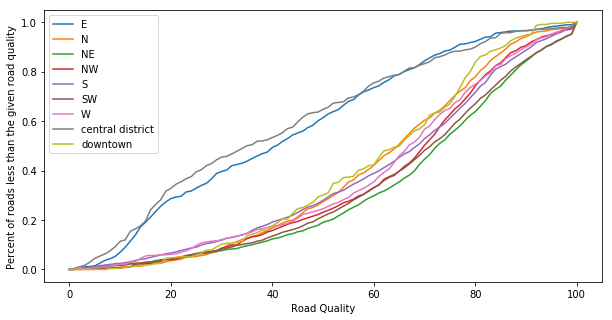

In [80]:
plt.figure(figsize=[10,5])
plt.plot(agg.T,'-')
plt.xlabel("Road Quality")
plt.ylabel("Percent of roads less than the given road quality")
plt.legend(agg.T,loc=0)
plt.show()

<div id='results-type-code'/>
### Road Type Analysis

The dataset contains a few types of roads. Analyzing the breakout for each group, we see that E and Central District have a higher percentage of AC road than the other types. The possible types ares: 

* AC = Asphalt Concrete
* PCC = Rigid Pavement
* AC/PCC = Composite AC and PCC
* ST = Bituminous Surface Treatment

The AC roads, as seen in the last table, have the lowest quality scores. These roads are the driving factor of why the Central District and E have the worst roads.

In [152]:
# Counts of roads by region and road type
filtered_data.pivot_table(values = 'STNAME_ORD',
                 index = 'region',
                 columns = 'SURFACETYPE_1',
                 aggfunc = 'count',
                 margins_name = "Total",
                 margins=True
                ).fillna(0).astype('int')

SURFACETYPE_1,,AC,AC/AC,AC/PCC,PCC,ST,Total
region,,,,,,,
E,6,618,8,354,517,0,1503
N,0,212,36,460,1386,454,2548
NE,0,347,30,653,1504,1187,3721
NW,1,284,28,202,1299,477,2291
S,1,900,54,757,1852,699,4263
SW,0,293,7,234,1565,446,2545
W,6,256,3,210,738,37,1250
central district,1,360,7,119,231,1,719
downtown,1,16,1,307,146,0,471


In [153]:
# Mean condition of roads by region and road type
filtered_data.pivot_table(values = ['PVMTCONDINDX1'],
                 index = 'region',
                 columns = 'SURFACETYPE_1',
                 aggfunc = 'mean',
                 fill_value='na'
                )

PVMTCONDINDX1                                              \
SURFACETYPE_1                          AC      AC/AC     AC/PCC        PCC   
region                                                                       
E                      64.3333  26.574434  57.125000  40.759887  61.518375   
N                           na  39.797170  75.833333  57.702174  63.289322   
NE                          na  41.495677  60.800000  61.113323  71.976729   
NW                          69  48.345070  62.857143  53.891089  67.511162   
S                           88  47.206667  73.444444  58.190225  71.824514   
SW                          na  47.559727  68.857143  53.213675  72.758466   
W                           87  44.390625  71.333333  55.661905  73.546070   
central district            19  24.519444  69.142857  42.369748  63.025974   
downtown                    85  43.562500  80.000000  57.055375  71.767123   

                           
SURFACETYPE_1          ST  
region                     
E                      na  
N                 74.1432  
NE                77.7616  
NW                75.5702  
S                 67.8312  
SW                70.1143  
W                 37.3514  
central district       26  
downtown               na